In [1]:
#asthma/notebooks/data_augmentation.ipynb
import os
import sys
os.chdir("./..")
sys.path.append(os.getcwd())

import yaml
import glob
import shutil
from tqdm import trange

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

import cv2
import albumentations as A

from utils.paths import REPO_PATH
from utils.formatting import yolo_to_coco, coco_to_yolo, yolo_to_pascalVoc, pascalVoc_to_yolo, unnormalize_bbox

In [2]:
NUM_BOUNDING_BOXES_PER_CLASS = 1000

In [3]:
INHALER_META_PATH = f"{REPO_PATH}/data/inhaler.yaml"
READ_PATH = f"{REPO_PATH}/data/train"
SAVE_PATH = f"{REPO_PATH}/data/augmented_dataset"

os.makedirs(f"{SAVE_PATH}/images", exist_ok=True)
os.makedirs(f"{SAVE_PATH}/labels", exist_ok=True)

with open(INHALER_META_PATH, 'r') as file:
    inhaler_meta = yaml.load(file, Loader=yaml.FullLoader)["names"]

In [4]:
all_image_paths = [filename.replace("\\", "/") for filename in glob.glob(f"{READ_PATH}/images/*.jpg", recursive=True)]
all_image_filenames = [filename.split("/")[-1] for filename in all_image_paths]
all_label_paths = []
for image_filename in all_image_filenames:
    label_path = image_filename.replace(".jpg", ".txt").replace("images", "labels")
    all_label_paths.append(f"{READ_PATH}/labels/{label_path}")

all_image_paths = sorted(all_image_paths, key=lambda x: x.split("/")[-1])
all_label_paths = sorted(all_label_paths, key=lambda x: x.split("/")[-1])

Count the number of classes in all the bounding boxes

In [5]:
class_file_paths = {}
for label_path in all_label_paths:
    with open(label_path, "r") as f:
        lines = f.readlines()
        class_id = [int(line.split(" ")[0]) for line in lines]
        for id in class_id:
            id = inhaler_meta[id]
            if id not in class_file_paths:
                class_file_paths[id] = []
            class_file_paths[id].append(label_path)

max_count = 0
max_count_class = ""
for k, v in class_file_paths.items():
    print(f"{k}: {len(v)}")
    if len(v) > max_count:
        max_count = len(v)
        max_count_class = k

print(f"Will generate {max_count} bounding boxes for each class")

mouth_closed: 1920
mouth_opened: 874
inhaler_hand: 716
cap_hand: 442
mouth_sealed_on_inhaler: 312
Will generate 1920 bounding boxes for each class


Reading the images and labels

In [6]:
def read_image(path):
    return np.array(Image.open(path))

def read_label(path, output_format:str="yolo", normalize:bool=True, image_size:tuple=None):
    """
    Reads in the labels that are stored in the yolo format
    """
    assert output_format.lower() in ("yolo", "coco", "pascal_voc"), "output_format must be either 'yolo' or 'coco' or 'pascal_voc'"
    assert normalize in (True, False), "normalize must be either True or False"
    assert (normalize or image_size is not None), "if normalize is False, image_size must be provided"
    labels = []
    classes = []
    with open(path, "r") as f:
        data = f.read()
        for line in data.split("\n"):
            if line:
                label = line.split(" ")
                class_id = int(label[0])
                bbox = list(map(float, label[1:]))
                if not normalize:
                    bbox = np.array(bbox)
                    bbox[[0, 2]] *= image_size[1]
                    bbox[[1, 3]] *= image_size[0]
                    bbox = bbox.astype(int).tolist()
                labels.append(bbox)
                classes.append(class_id)
    
    if output_format == "yolo":
        return labels, classes
    elif output_format == "coco":
        return yolo_to_coco(labels), classes
    elif output_format == "pascal_voc":
        return yolo_to_pascalVoc(labels), classes

In [7]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White

def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35,
        color=TEXT_COLOR,
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    """
    Visualizes the image with the bounding boxes.
    Bounding boxes are expected to be unnormalized, and presented in the COCO format: (x_min, y_min, width, height)
    """
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    # plt.axis('off')
    plt.imshow(img)

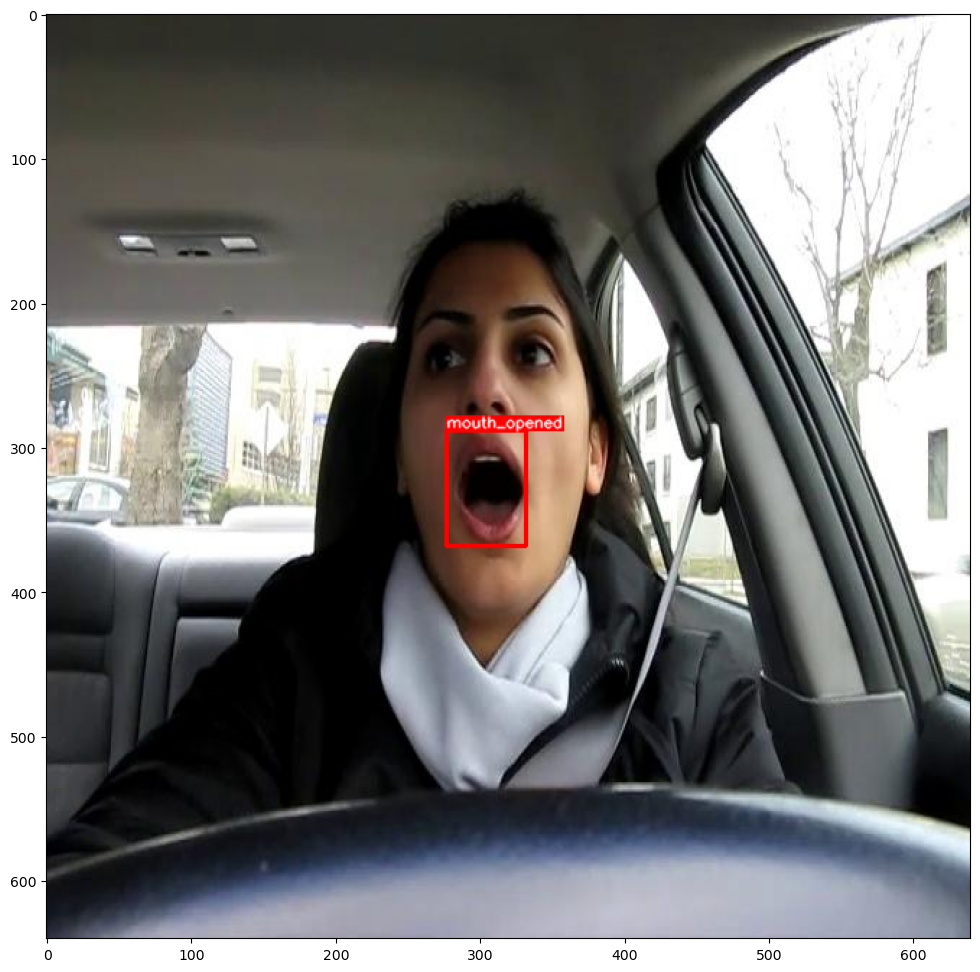

In [8]:
# Visualize an image with the bounding boxes
i = 520
image = read_image(all_image_paths[i])
bboxes, classes = read_label(all_label_paths[i], normalize=False, image_size=image.shape[:-1], output_format="coco")
visualize(image, bboxes, classes, inhaler_meta)

Augmentations

In [9]:
accumulated_classes = {}
saved_label_paths = set()

# Step 1: We save all the images that contain the class with the maximum count (up to NUM_BOUNDING_BOXES_PER_CLASS)
max_count_class_num_bounding_boxes = 0
class_file_paths_max = class_file_paths[max(class_file_paths, key=lambda x: len(class_file_paths[x]))]
for label_path in class_file_paths_max:
    if label_path in saved_label_paths:
        continue
    elif max_count_class_num_bounding_boxes >= NUM_BOUNDING_BOXES_PER_CLASS:
        break
    
    saved_label_paths.add(label_path)
    image_path = label_path.replace("labels", "images").replace(".txt", ".jpg")
    with open(label_path, "r") as f:
        lines = f.readlines()
        class_id = [int(line.split(" ")[0]) for line in lines]
        for id in class_id:
            id = inhaler_meta[id]
            if id not in accumulated_classes:
                accumulated_classes[id] = []
            accumulated_classes[id].append(label_path)
            if id == max_count_class:
                max_count_class_num_bounding_boxes += 1
    shutil.copy(image_path, f"{SAVE_PATH}/images/{image_path.split('/')[-1]}")
    shutil.copy(label_path, f"{SAVE_PATH}/labels/{label_path.split('/')[-1]}")

for k, v in accumulated_classes.items():
    print(f"{k}: {len(v)} Bounding Boxes")

mouth_closed: 1000 Bounding Boxes
inhaler_hand: 389 Bounding Boxes
cap_hand: 189 Bounding Boxes


In [10]:
# Step 2: We add the images that do not contain the class with the maximum count
images_to_augment = {}
for k, v in class_file_paths.items():
    if k == max(class_file_paths, key=lambda x: len(class_file_paths[x])):
        continue
    for label_path in v:
        if label_path in saved_label_paths:
            continue
        
        image_path = label_path.replace("labels", "images").replace(".txt", ".jpg")
        with open(label_path, "r") as f:
            lines = f.readlines()
            class_id = [int(line.split(" ")[0]) for line in lines]
            if max_count_class in list(map(lambda id: inhaler_meta[id], class_id)):
                continue
            for id in class_id:
                id = inhaler_meta[id]
                assert id != max_count_class
                if id not in accumulated_classes:
                    accumulated_classes[id] = []
                accumulated_classes[id].append(label_path)
        saved_label_paths.add(label_path)

        images_to_augment[label_path] = list(map(lambda x: inhaler_meta[x], sorted(class_id)))
        shutil.copy(image_path, f"{SAVE_PATH}/images/{image_path.split('/')[-1]}")
        shutil.copy(label_path, f"{SAVE_PATH}/labels/{label_path.split('/')[-1]}")

images_to_augment

{'c:/Users/ernes/Git/asthma/data/train/labels/100_jpg.rf.923362a170d92e94ee9e1a15ee3e22d0.txt': ['mouth_opened'],
 'c:/Users/ernes/Git/asthma/data/train/labels/102_jpg.rf.d748282b63b3eba8033ea53194698658.txt': ['mouth_opened'],
 'c:/Users/ernes/Git/asthma/data/train/labels/103_jpg.rf.0ad1ce9b24a2c33d266bd3d5e78e5e87.txt': ['mouth_opened'],
 'c:/Users/ernes/Git/asthma/data/train/labels/104_jpg.rf.b6a0ab1e23fd42e9bd7077f35ce7b55e.txt': ['mouth_opened'],
 'c:/Users/ernes/Git/asthma/data/train/labels/105_jpg.rf.a92f58b34d6c9e4afe67c11b308759ed.txt': ['mouth_opened'],
 'c:/Users/ernes/Git/asthma/data/train/labels/108_jpg.rf.8404fe84df8f4a07543397b4c6b71795.txt': ['mouth_opened'],
 'c:/Users/ernes/Git/asthma/data/train/labels/10_jpg.rf.47e7f5d55e63c4be681de571ced641ff.txt': ['mouth_opened'],
 'c:/Users/ernes/Git/asthma/data/train/labels/110_jpg.rf.35f3e79cfa42d0ecd824d631572e7b79.txt': ['mouth_opened'],
 'c:/Users/ernes/Git/asthma/data/train/labels/111_jpg.rf.00902ee53f353efb3f1ec7257eb10bd0

In [11]:
classes_to_augment = {max_count_class: 0}
for k, v in accumulated_classes.items():
    print(f"{k}: {len(v)} Bounding Boxes")
    if len(v) < NUM_BOUNDING_BOXES_PER_CLASS:
        classes_to_augment[k] = NUM_BOUNDING_BOXES_PER_CLASS - len(v)
classes_to_augment_sorted = sorted(classes_to_augment.items(), key=lambda x: x[1], reverse=True)
classes_to_augment_sorted

mouth_closed: 1000 Bounding Boxes
inhaler_hand: 523 Bounding Boxes
cap_hand: 293 Bounding Boxes
mouth_opened: 707 Bounding Boxes
mouth_sealed_on_inhaler: 161 Bounding Boxes


[('mouth_sealed_on_inhaler', 839),
 ('cap_hand', 707),
 ('inhaler_hand', 477),
 ('mouth_opened', 293),
 ('mouth_closed', 0)]

In [12]:
# Step 3: We augment the images that do not contain the class with the maximum count
transform = A.Compose([
    # A.RandomSizedBBoxSafeCrop(512, 512, p=0.5, erosion_rate=0.2), # This is not working
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5, brightness_limit=0.3, contrast_limit=0.3),
    A.RandomGamma(p=0.5, gamma_limit=(30, 200)),
    A.Blur(p=0.5, blur_limit=(0, 7)),
    A.HueSaturationValue(p=0.5, hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20),
], bbox_params=A.BboxParams(format='albumentations', min_visibility=1.0, label_fields=['class_labels']))

In [13]:
while np.sum(np.array(list(classes_to_augment.values())) > 0) > 0:
    
    # Finding the class with the most number of bounding boxes to augment
    class_name, num_to_augment = None, 0
    for k, v in classes_to_augment.items():
        if v > num_to_augment:
            class_name, num_to_augment = k, v
    print(" " * 200, end="\r")
    print(f"Augmenting {num_to_augment} bounding boxes for {class_name}", end="\r")

    label_path = random.choice(class_file_paths[class_name])
    image_path = label_path.replace("labels", "images").replace(".txt", ".jpg")
    image = read_image(image_path)
    image_shape = image.shape[:-1]

    # Checking if the bounding boxes in the image are more than NUM_BOUNDING_BOXES_PER_CLASS
    to_continue = False
    bboxes, class_ids = read_label(label_path, normalize=True, image_size=image_shape, output_format="pascal_voc")
    class_names = list(map(lambda x: inhaler_meta[x], class_ids))
    for _class_name in class_names:
        if classes_to_augment[_class_name] <= 0:
            to_continue = True
            break
    if to_continue:
        if label_path in class_file_paths[class_name]:
            class_file_paths[class_name].remove(label_path)
        continue

    # Augmenting the image
    transformed = transform(image=image, bboxes=bboxes, class_labels=class_names)
    transformed_image = transformed["image"]
    transformed_bbox = pascalVoc_to_yolo(transformed["bboxes"])
    transformed_class_id = []
    for _class_name in transformed["class_labels"]:
        for key, value in inhaler_meta.items():
            if value == _class_name:
                transformed_class_id.append(key)
    
    # Saving the augmented image
    image_filename = image_path.split("/")[-1].split(".")[0]
    augmented_image_filename = f"{image_filename}-augmented-{num_to_augment}.jpg"
    augmented_label_filename = f"{image_filename}-augmented-{num_to_augment}.txt"
    cv2.imwrite(f"{SAVE_PATH}/images/{augmented_image_filename}", transformed_image)
    with open(f"{SAVE_PATH}/labels/{augmented_label_filename}", "w") as f:
        for i, bbox in enumerate(transformed_bbox):
            f.write(f"{transformed_class_id[i]} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")

    # Updating the number of bounding boxes left to augment
    for _class_name in class_names:
        classes_to_augment[_class_name] -= np.sum(np.array(class_names) == _class_name)

IndexError: list index out of range

Cross-check that the augmented dataset is balanced

In [14]:
all_image_paths = [filename.replace("\\", "/") for filename in glob.glob(f"{SAVE_PATH}/images/*.jpg", recursive=True)]
all_image_filenames = [filename.split("/")[-1] for filename in all_image_paths]
all_label_paths = []
for image_filename in all_image_filenames:
    label_path = image_filename.replace(".jpg", ".txt").replace("images", "labels")
    all_label_paths.append(f"{SAVE_PATH}/labels/{label_path}")

all_image_paths = sorted(all_image_paths, key=lambda x: x.split("/")[-1])
all_label_paths = sorted(all_label_paths, key=lambda x: x.split("/")[-1])

In [15]:
class_file_paths = {}
for label_path in all_label_paths:
    with open(label_path, "r") as f:
        lines = f.readlines()
        class_id = [int(line.split(" ")[0]) for line in lines]
        for id in class_id:
            id = inhaler_meta[id]
            if id not in class_file_paths:
                class_file_paths[id] = []
            class_file_paths[id].append(label_path)

max_count = 0
max_count_class = ""
for k, v in class_file_paths.items():
    print(f"{k}: {len(v)}")
    if len(v) > max_count:
        max_count = len(v)
        max_count_class = k

mouth_closed: 1000
mouth_opened: 1000
inhaler_hand: 983
cap_hand: 912
mouth_sealed_on_inhaler: 983
